In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("data/target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")
df

,Standardized_SMILES,pchembl_value
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05
...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

def calculate_molwt(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    return None

def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolLogP(mol)
    return None
def calculate_QED(smiles):
    mol=Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.QED.default(mol)
    return

df['MolWt'] =df['Standardized_SMILES'].apply(calculate_molwt)
df['LogP'] = df['Standardized_SMILES'].apply(calculate_logp)
df['QED'] = df['Standardized_SMILES'].apply(calculate_QED)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


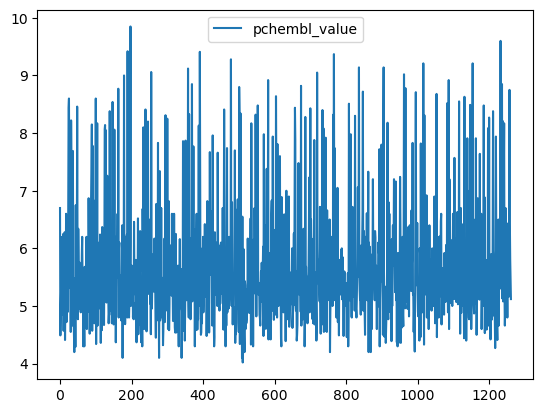

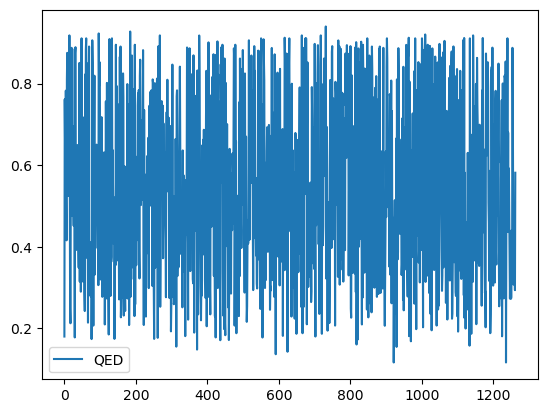

In [5]:
import random
df_copy=df = df.sample(frac=1).reset_index(drop=True)
df_copy.plot(y="pchembl_value",use_index=False) 
df_copy.plot(y="QED",use_index=False) 
df=df_copy

In [6]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [8]:
smiles = df['Standardized_SMILES'].values

In [9]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [12]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,Cc1ncoc1-c1nnc(SCCCN2CCc3cc4nc(C(F)(F)C(F)(F)F...,6.70,542.534,5.15682,0.179992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CN(C)C(=O)c1ccc(-c2ccc3c(c2)CCN(CCN2CCCC2)C3=O...,4.49,409.505,3.28860,0.761287,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,COC(C)CN(CCc1ccc(Cl)cc1)C1CCN(c2nc(=N)[nH][nH]...,4.97,392.935,2.41907,0.643751,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc(N2CC3CNCC(C2)O3)ccc1N=c1nc(-c2cnc3ccccn...,5.28,477.956,2.79580,0.469368,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CC(C)Oc1cccc(N2CCN(CCN3Cc4ccccc4C3)C2=O)c1,5.40,365.477,3.73160,0.782513,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,COc1cc(OC)c2nccc(CCC34CCC(NCc5ccc6c(n5)NC(=O)C...,8.75,505.575,3.17710,0.476016,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,COc1ccc2ncc(C#N)c(CCC34CCC(NCc5ccc6c(n5)NC(=O)...,6.43,500.559,3.04018,0.502368,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,COC(=O)C1(COc2ccc3ncc(F)c(CCC45CCC(NCc6ccc7c(n...,5.80,591.640,3.63100,0.336825,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,NCC(O)COc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5)NC...,5.48,552.607,1.99740,0.293651,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
#Now incorporate this sort of noise into df during the training

In [13]:
X.shape

(1262, 20488)

In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("fcv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.6406800219365012, pvalue=6.519575206697649e-16)
PearsonRResult(statistic=0.8368675959687887, pvalue=3.0238187219195967e-34)
PearsonRResult(statistic=0.8283797392366391, pvalue=5.3202153538513794e-33)
PearsonRResult(statistic=0.8454734896237952, pvalue=1.3891821492494484e-35)
PearsonRResult(statistic=0.7995976385123824, pvalue=3.0790041212166754e-29)
PearsonRResult(statistic=0.8452835907586325, pvalue=1.489887050595609e-35)
PearsonRResult(statistic=0.8181010007992766, pvalue=1.3984766678325473e-31)
PearsonRResult(statistic=0.8120479693623177, pvalue=8.718574734492677e-31)
PearsonRResult(statistic=0.8358923058298293, pvalue=1.2670355539525222e-34)


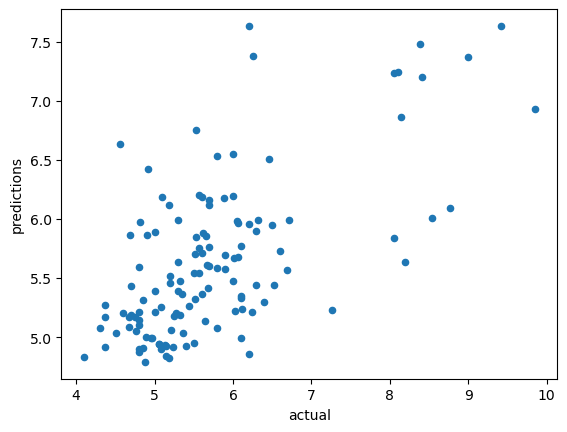

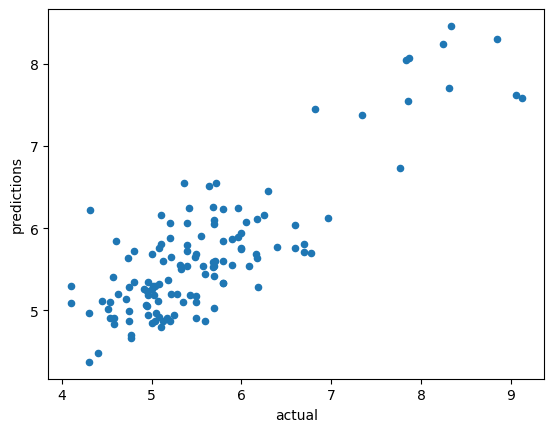

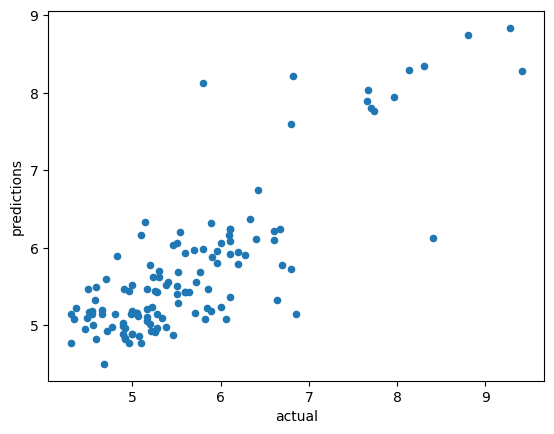

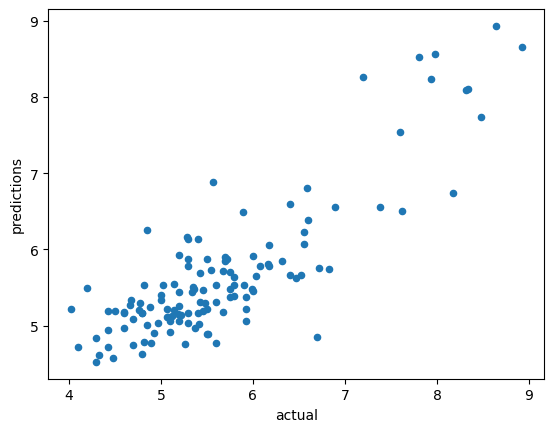

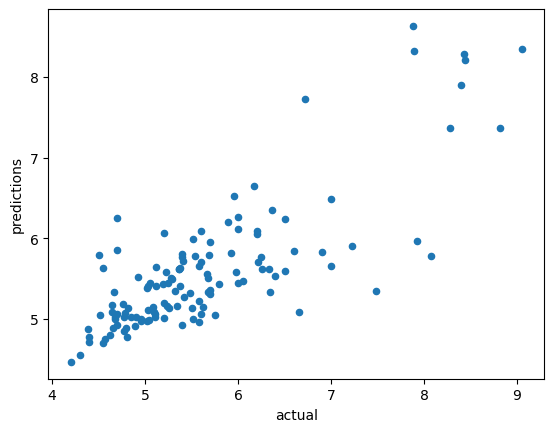

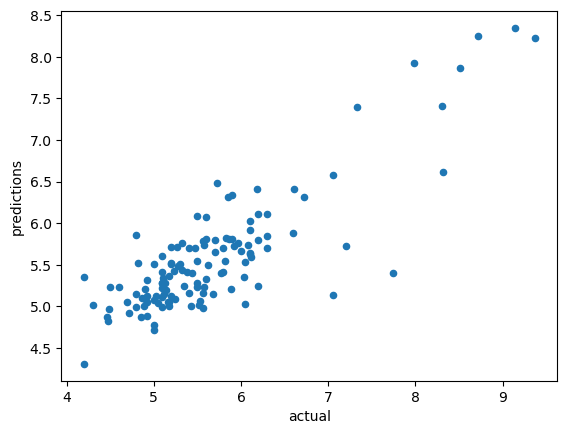

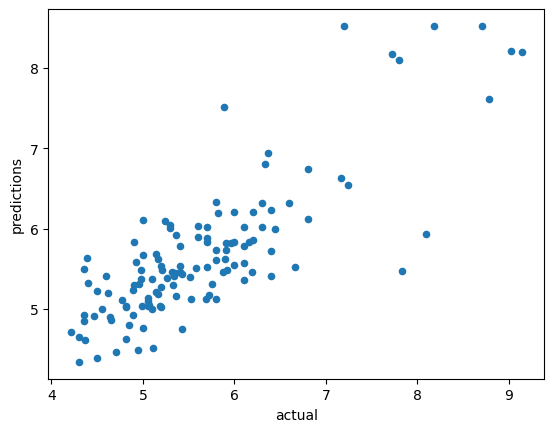

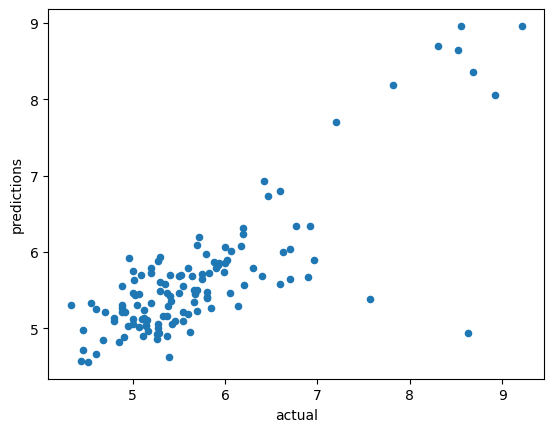

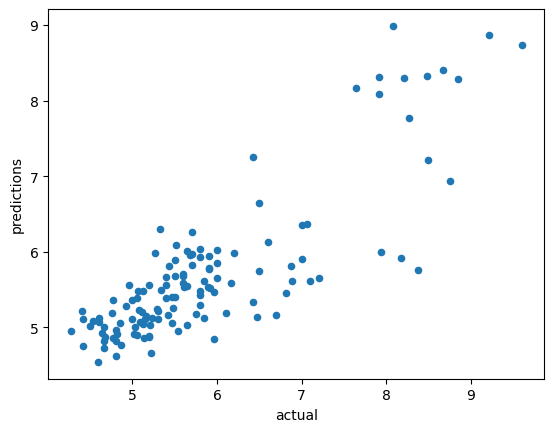

In [15]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [16]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(26, 3)
(28, 3)
(35, 3)
(28, 3)
(35, 3)
(28, 3)
(30, 3)
(21, 3)
(32, 3)


In [17]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(11, 3)
(11, 3)
(13, 3)
(14, 3)
(11, 3)
(10, 3)
(6, 3)
(15, 3)
(14, 3)


In [18]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(17, 3)
(22, 3)
(13, 3)
(15, 3)
(12, 3)
(17, 3)
(18, 3)
(18, 3)
(9, 3)


In [19]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(70, 3)
(63, 3)
(63, 3)
(65, 3)
(65, 3)
(67, 3)
(69, 3)
(69, 3)
(71, 3)


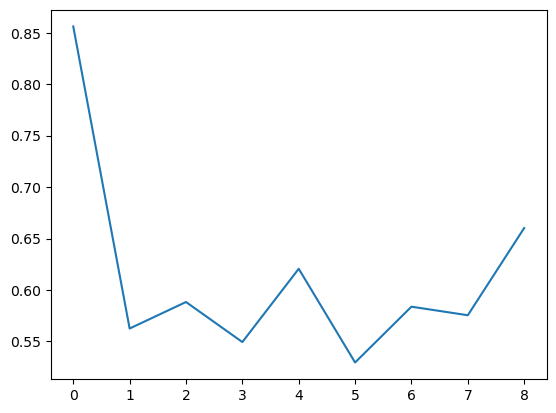

In [20]:
plt.plot(rmse)
plt.show()

In [21]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

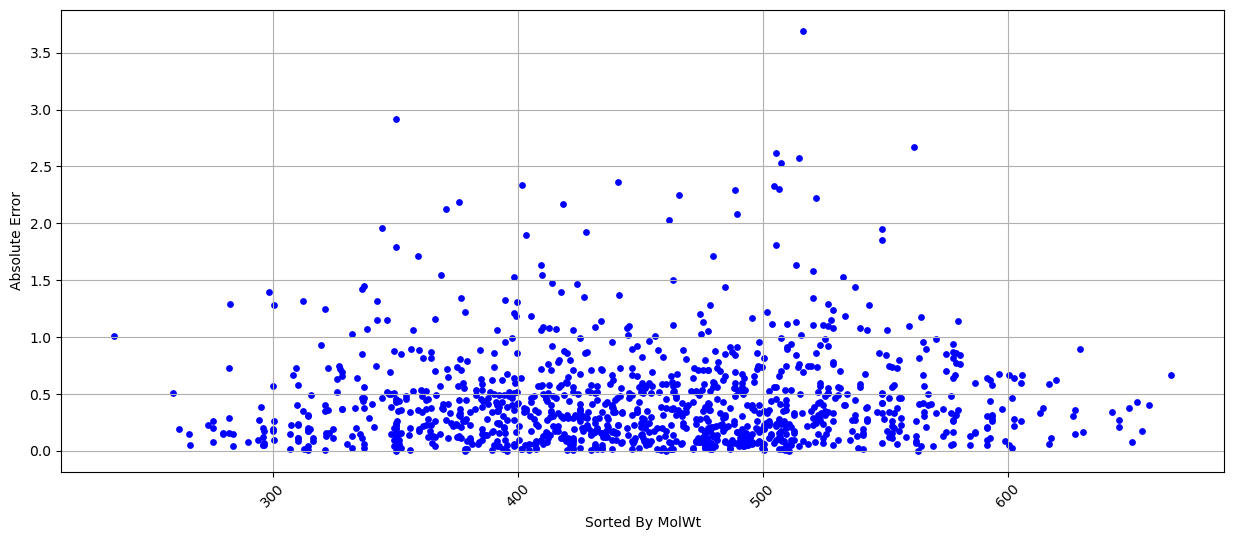

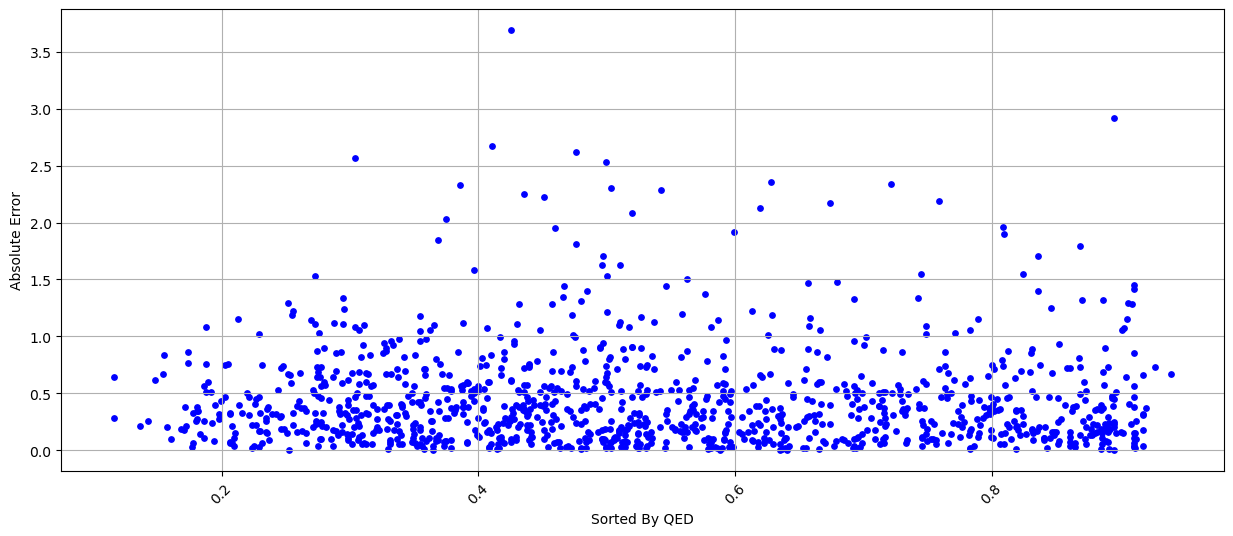

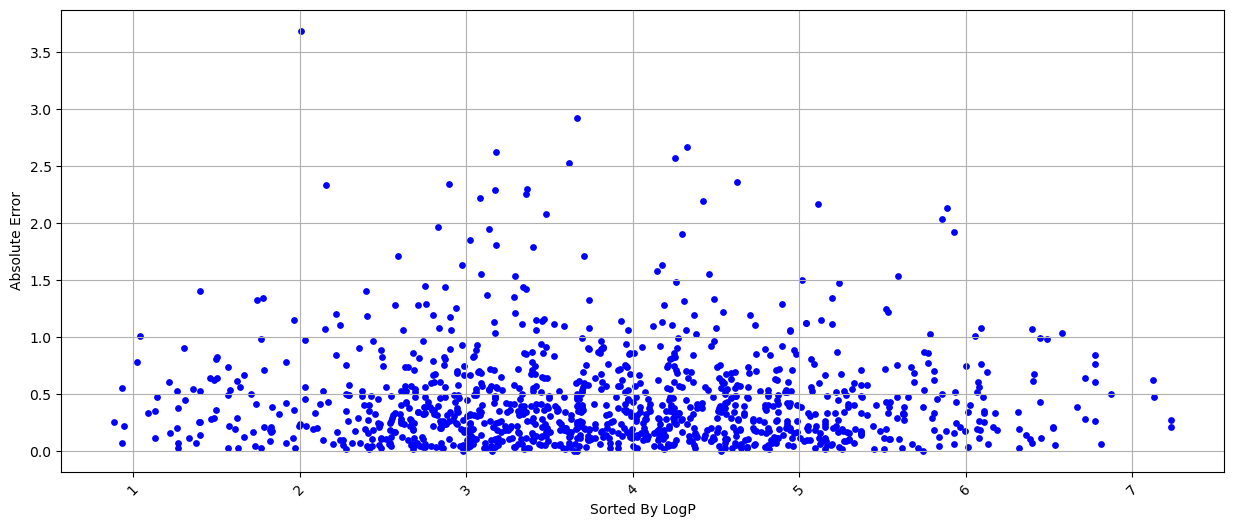

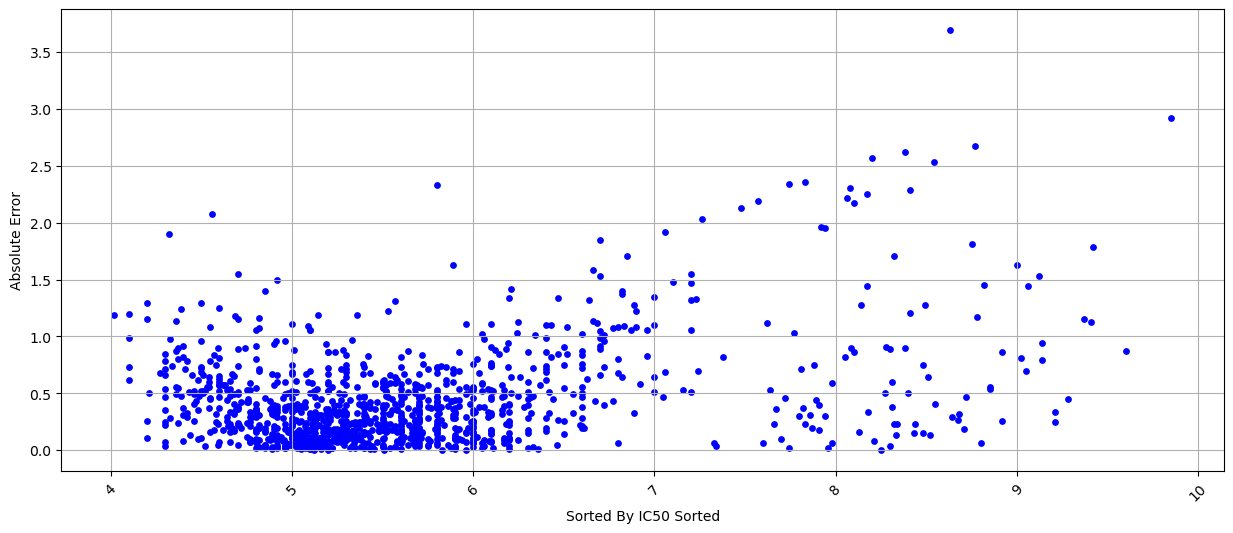

In [22]:
plot_graphs(df, results_df)

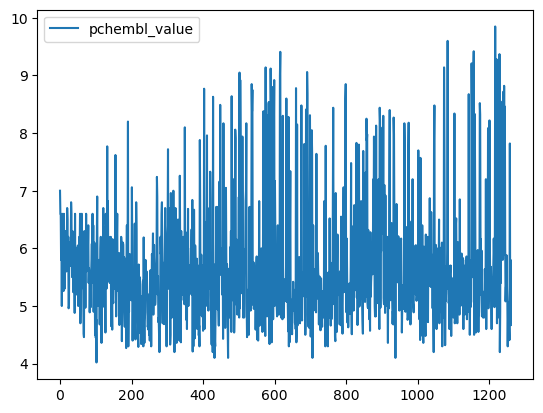

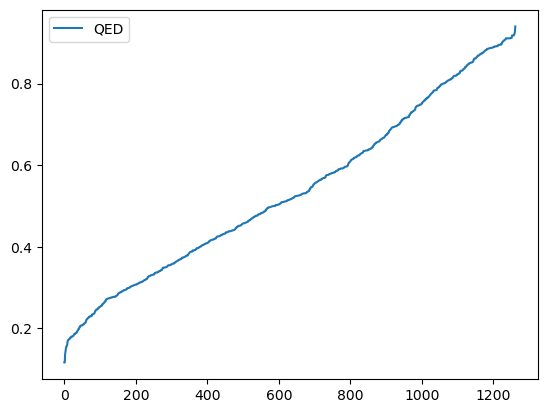

In [62]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(126, ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [63]:
smiles1.shape

(1136,)

In [64]:
smiles_test.shape

(126,)

In [65]:
y_test.shape

(126,)

In [66]:
y1.shape

(1136,)

In [76]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-2):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame

    # Saving to CSV (optional)
    

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.3141695674700665, pvalue=0.00034025664735413887)
PearsonRResult(statistic=-0.3347660693069352, pvalue=0.00012739238253011673)
PearsonRResult(statistic=-0.16591689814786326, pvalue=0.06334781922654405)
PearsonRResult(statistic=-0.18712132375770285, pvalue=0.03589918687751514)
PearsonRResult(statistic=0.7571562512964738, pvalue=1.0993905030273026e-24)
PearsonRResult(statistic=0.8338054923869095, pvalue=8.668154735309024e-34)
PearsonRResult(statistic=0.831559749455946, pvalue=1.851346240470895e-33)
PearsonRResult(statistic=0.8172223746739246, pvalue=1.8316565565130076e-31)


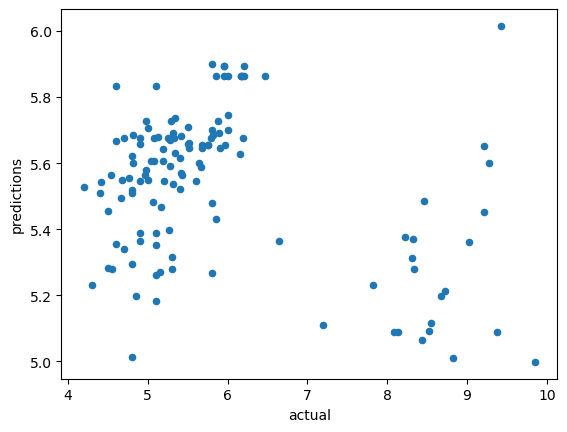

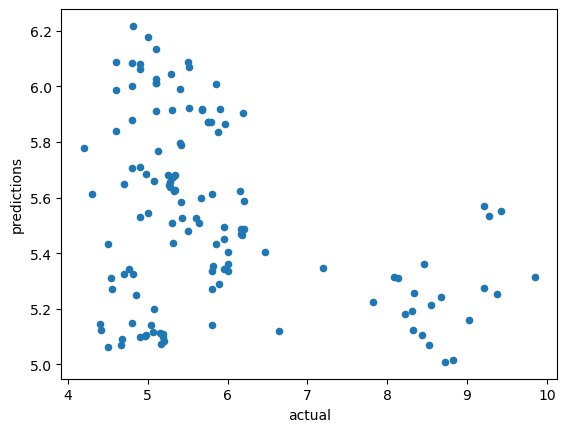

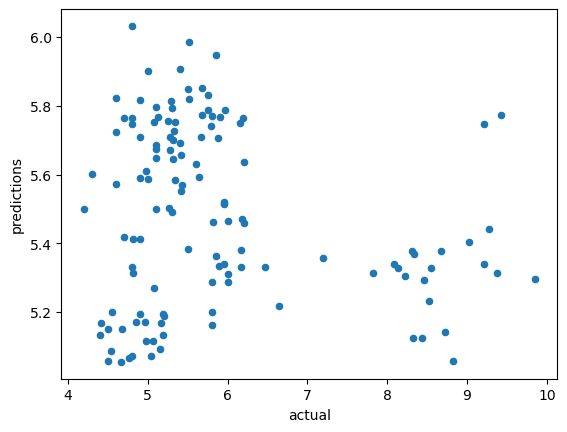

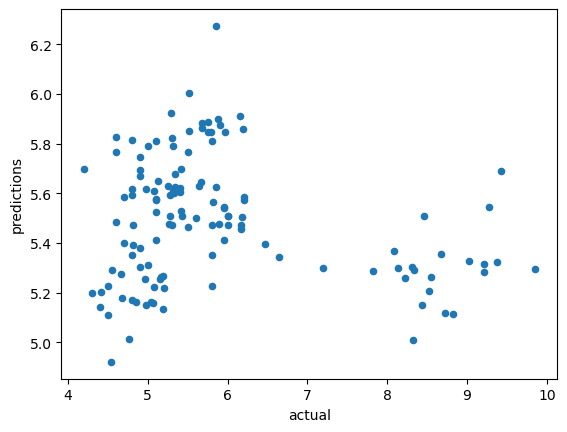

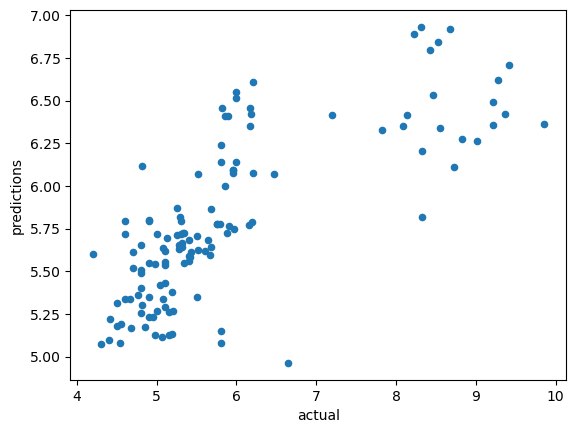

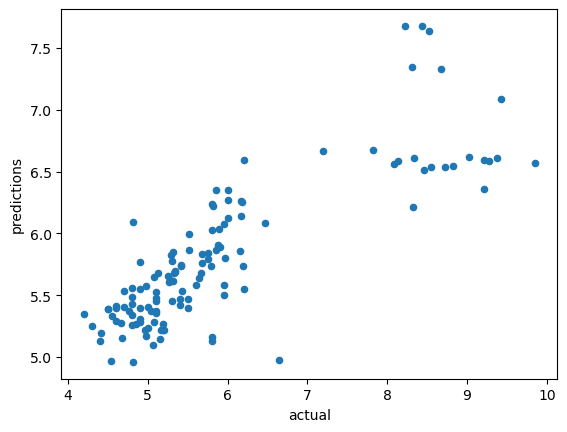

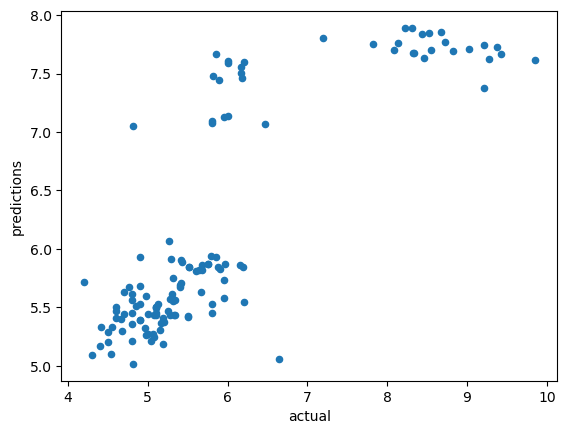

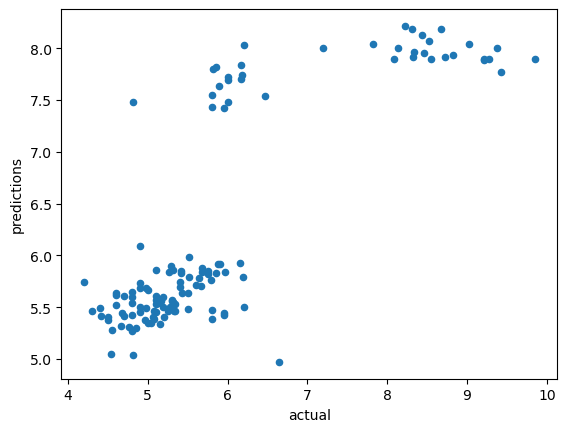

In [77]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [79]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(3, 3)
(15, 3)
(19, 3)
(12, 3)
(11, 3)
(8, 3)
(5, 3)
(2, 3)


In [80]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(10, 3)
(10, 3)
(5, 3)
(4, 3)
(3, 3)
(3, 3)
(1, 3)
(1, 3)


In [81]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(67, 3)
(67, 3)
(72, 3)
(73, 3)
(74, 3)
(74, 3)
(76, 3)
(76, 3)


In [82]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(45, 3)
(32, 3)
(29, 3)
(36, 3)
(37, 3)
(40, 3)
(43, 3)
(46, 3)


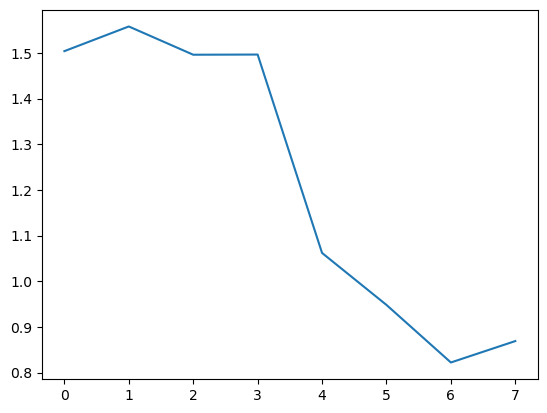

In [83]:
plt.plot(rmse)
plt.show()